In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cpu


In [3]:
DATAFILE = 'AME2020.csv'
MODELFILE = 'nuclear_model.dict'

# Load the data
df = pd.read_csv(DATAFILE)

# Remove rows with missing binding energy (-999)
df = df[df['bindingE'] != -999]

# Proceed with the remaining steps
FEATURES = ['N', 'Z', 'A']
TARGET = 'bindingE'

In [4]:
print(len(df))

2550


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

df[FEATURES] = scaler_x.fit_transform(df[FEATURES])
df[TARGET] = scaler_y.fit_transform(df[[TARGET]])

In [6]:
print(df[:5])

  name        N         Z         A  Mexcess  eMexcess  bindingE  ebindingE   
0   Rn  0.76250  0.781818  0.769517   -9.655  0.010163  0.886261   0.000049  \
1   Ho  0.52500  0.609091  0.557621  -63.620  0.008298  0.926201   0.000055   
2   Pr  0.45000  0.536364  0.483271  -74.300  0.046995  0.942190   0.000359   
3   Au  0.71875  0.718182  0.717472  -32.210  0.002118  0.900418   0.000011   
4   Ta  0.58750  0.663636  0.617100  -48.350  0.027945  0.911798   0.000167   

   betaE    ebetaE     atomicM  eatomticM  
0 -6.990  0.015466  207.989635   0.010910  
1 -5.356  0.018442  150.931698   0.008908  
2 -6.533  0.053081  130.920235   0.050451  
3 -0.028  0.003581  193.965419   0.002273  
4 -6.258  0.033626  166.948093   0.030000  


In [7]:
NTRAIN = int(0.6 * len(df))
NVALID = int(0.3 * len(df))
NTEST = len(df) - NTRAIN - NVALID

train_data = df[:NTRAIN]
valid_data = df[NTRAIN:NTRAIN+NVALID]
test_data = df[NTRAIN+NVALID:]

In [8]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

1530
765
255


In [9]:
def dataframe_to_tensor(df, target, features):
    x = torch.tensor(df[features].to_numpy()).float().to(DEVICE)
    y = torch.tensor(df[target].to_numpy()).float().to(DEVICE)
    return x, y

train_x, train_y = dataframe_to_tensor(train_data, TARGET, FEATURES)
valid_x, valid_y = dataframe_to_tensor(valid_data, TARGET, FEATURES)
test_x, test_y = dataframe_to_tensor(test_data, TARGET, FEATURES)

In [10]:
H = 15
model = nn.Sequential(
    nn.Linear(len(FEATURES), H),
    nn.SiLU(),
    nn.LayerNorm(H),
    nn.Linear(H, H),
    nn.SiLU(),
    nn.LayerNorm(H),
    nn.Linear(H, H),
    nn.SiLU(),
    nn.LayerNorm(H),
    nn.Linear(H, 1)
).to(DEVICE)

In [11]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
n_epochs = 20000
batch_size = 32

def train_epoch(model, optimizer, criterion, train_x, train_y, batch_size):
    model.train()
    epoch_loss = 0.0
    for i in range(0, len(train_x), batch_size):
        x_batch = train_x[i:i+batch_size]
        y_batch = train_y[i:i+batch_size].view(-1, 1)
        
        optimizer.zero_grad()
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * x_batch.size(0)  # Scale loss back to total sum
    return epoch_loss / len(train_x)  

In [13]:
def validate_model(model, criterion, valid_x, valid_y):
    model.eval()
    with torch.no_grad():
        predictions = model(valid_x).view(-1, 1)
        loss = criterion(predictions, valid_y.view(-1, 1))
    return loss.item()

In [14]:
best_loss = float('inf')
train_losses = []
valid_losses = []
X=[]
T=[]
V=[]
for epoch in range(n_epochs):
    train_loss = train_epoch(model, optimizer, criterion, train_x, train_y, batch_size)
    valid_loss = validate_model(model, criterion, valid_x, valid_y)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), MODELFILE)
    
    if epoch % 10 == 0:
        X.append(epoch)
        T.append(float(train_loss))
        V.append(float(valid_loss))

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}/{n_epochs} - Train Loss: {train_loss:9.3e}, Valid Loss: {valid_loss:9.3e}")

print("Training complete. Best validation loss:", best_loss)

Epoch 0/20000 - Train Loss: 3.813e-01, Valid Loss: 1.238e-02
Epoch 1000/20000 - Train Loss: 5.355e-05, Valid Loss: 1.600e-04
Epoch 2000/20000 - Train Loss: 2.936e-05, Valid Loss: 3.149e-04
Epoch 3000/20000 - Train Loss: 3.069e-05, Valid Loss: 4.014e-04
Epoch 4000/20000 - Train Loss: 2.204e-05, Valid Loss: 4.306e-04
Epoch 5000/20000 - Train Loss: 2.466e-05, Valid Loss: 4.824e-04
Epoch 6000/20000 - Train Loss: 1.405e-05, Valid Loss: 4.969e-04
Epoch 7000/20000 - Train Loss: 1.253e-05, Valid Loss: 5.037e-04
Epoch 8000/20000 - Train Loss: 1.169e-05, Valid Loss: 4.322e-04
Epoch 9000/20000 - Train Loss: 1.019e-05, Valid Loss: 4.684e-04
Epoch 10000/20000 - Train Loss: 9.629e-06, Valid Loss: 4.366e-04
Epoch 11000/20000 - Train Loss: 7.693e-06, Valid Loss: 4.585e-04
Epoch 12000/20000 - Train Loss: 9.651e-06, Valid Loss: 4.504e-04
Epoch 13000/20000 - Train Loss: 8.401e-06, Valid Loss: 4.761e-04
Epoch 14000/20000 - Train Loss: 8.582e-06, Valid Loss: 4.852e-04
Epoch 15000/20000 - Train Loss: 8.588e

In [15]:
import matplotlib.ticker as mticker
def plot_loss_curve(losses):
    
    xx, yy_t, yy_v = losses
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 3.8))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    
    ax.plot(xx, yy_t, color='red',  lw=1, label='training loss')
    ax.plot(xx, yy_v, color='blue', lw=1, label='validation loss')
    ax.legend()
    
    ax.set_xlabel('iterations')
    ax.set_ylabel('average loss')
    #ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_ylim(1e-4, 1e-2)
    #ax.set_xlim(1, 1e5)
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3, 3))  # Use scientific notation for numbers outside this range
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True, which="both", linestyle='-')
    plt.savefig("loss_curve.png", dpi=300)
    plt.show()

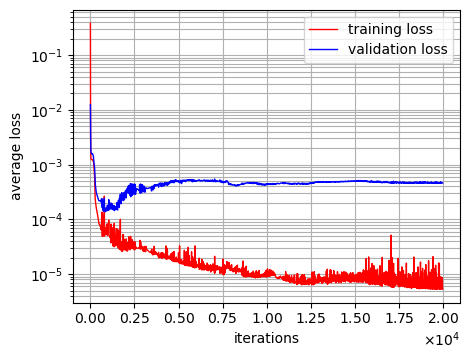

In [16]:
plot_loss_curve([X, T, V])

In [17]:
# Testing the model
model.load_state_dict(torch.load(MODELFILE, weights_only=True))
model.eval()

with torch.no_grad():
    test_predictions = model(test_x).cpu().numpy()
    test_actuals = test_y.cpu().numpy()

# Rescale the predictions and actual values back to the original scale
test_predictions = scaler_y.inverse_transform(test_predictions)
test_actuals = scaler_y.inverse_transform(test_actuals.reshape(-1, 1))

# Evaluate model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test_actuals, test_predictions)
rmse = np.sqrt(mean_squared_error(test_actuals, test_predictions))
r2 = r2_score(test_actuals, test_predictions)

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Test MAE: 0.0423
Test RMSE: 0.0935
R^2 Score: 0.9849


/opt/anaconda3/envs/mlphysics/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


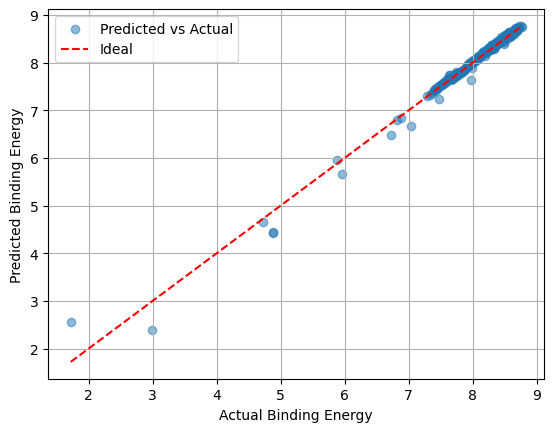

In [18]:
plt.scatter(test_actuals, test_predictions, alpha=0.5, label="Predicted vs Actual")
plt.plot([min(test_actuals), max(test_actuals)], [min(test_actuals), max(test_actuals)], color='red', linestyle='--', label="Ideal")
plt.xlabel("Actual Binding Energy")
plt.ylabel("Predicted Binding Energy")
plt.legend()
plt.grid(True)
plt.savefig("prediction_vs_actual.png", dpi=300)
plt.show()

In [29]:
comparison_df = pd.DataFrame({
    'Predictions': test_predictions.flatten(),  # Flatten to remove extra dimensions
    'Actuals': test_actuals.flatten()
})

# Print the comparison
print(comparison_df[20:50])

    Predictions   Actuals
20     7.805330  7.819196
21     8.205434  8.143362
22     8.386014  8.358178
23     8.377137  8.364286
24     8.552361  8.490555
25     7.998267  7.994817
26     7.866210  7.876017
27     8.343718  8.345738
28     4.421241  4.878520
29     8.277068  8.297954
30     8.307231  8.233578
31     8.566509  8.534669
32     8.269868  8.263821
33     8.689136  8.688137
34     8.369767  8.342340
35     8.145959  8.117587
36     7.543097  7.542328
37     8.449976  8.476914
38     8.141996  8.125926
39     8.096896  8.092561
40     8.434607  8.420548
41     8.499980  8.473269
42     7.943916  7.928489
43     8.388378  8.373762
44     8.323933  8.291538
45     8.520724  8.504346
46     8.326900  8.305297
47     7.712284  7.747508
48     8.717913  8.698564
49     8.306176  8.330578


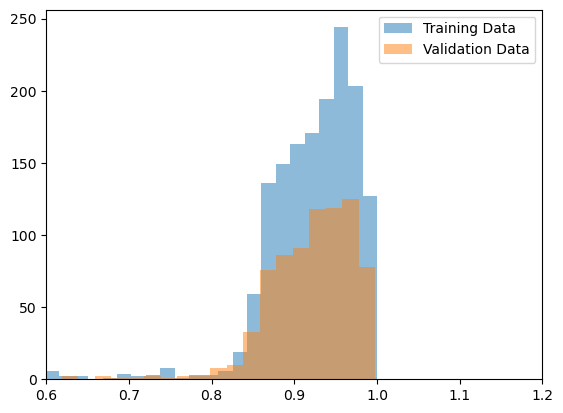

Standard deviation of bindingE in validation data: 0.0855
Standard deviation of bindingE in test data: 0.0867


In [20]:
# Visualize feature distributions for training and validation sets
plt.hist(train_data['bindingE'], bins=50, alpha=0.5, label='Training Data')
plt.hist(valid_data['bindingE'], bins=50, alpha=0.5, label='Validation Data')
plt.legend()
plt.xlim(0.6, 1.2)
plt.savefig("train_data_vs_valid_dat.png", dpi=300)
plt.show()

# Calculate the standard deviation for 'bindingE' in the validation and test sets
valid_std = valid_data['bindingE'].std()
test_std = test_data['bindingE'].std()

print(f"Standard deviation of bindingE in validation data: {valid_std:.4f}")
print(f"Standard deviation of bindingE in test data: {test_std:.4f}")

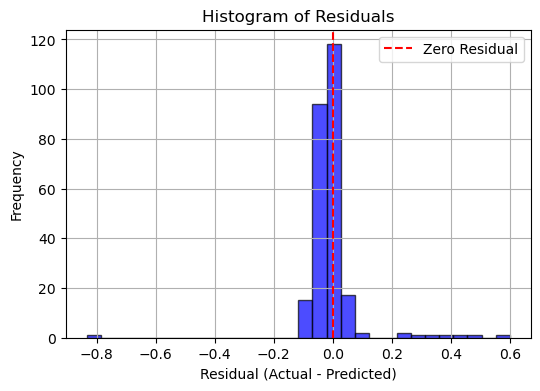

In [21]:
# Histogram of residuals
residuals = test_actuals.flatten() - test_predictions.flatten()

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', label='Zero Residual')
plt.title("Histogram of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.savefig("residuals.png", dpi=300)
plt.show()

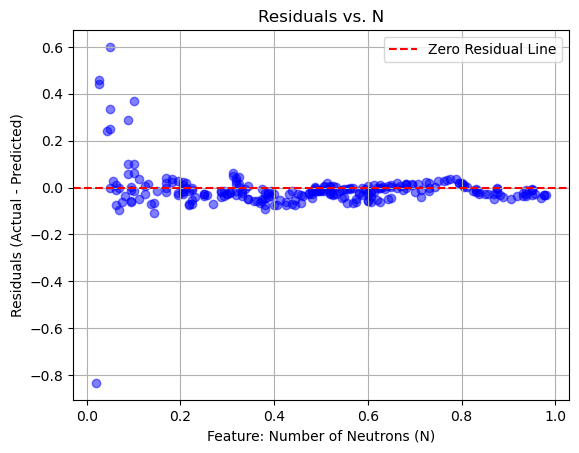

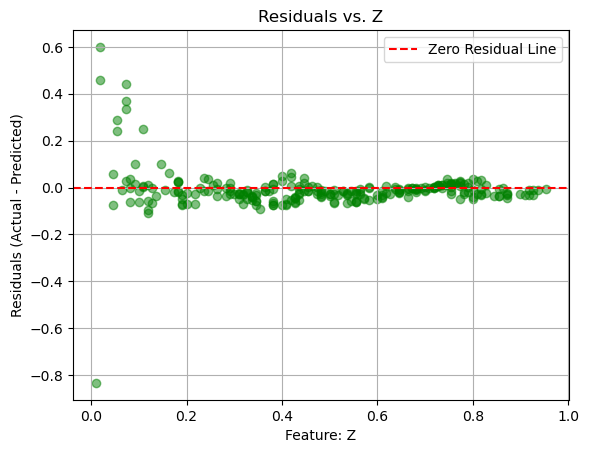

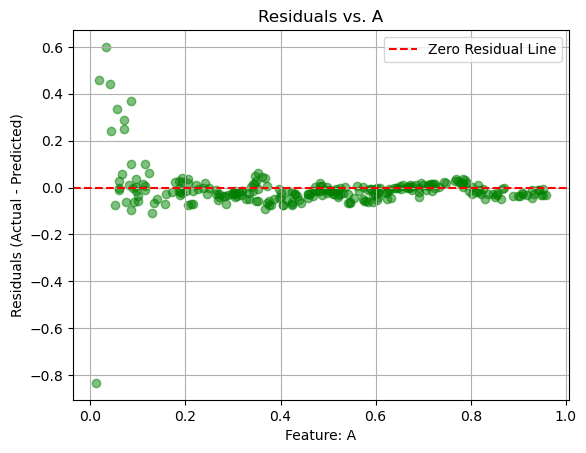

In [22]:
# Compute residuals
residuals = test_actuals.flatten() - test_predictions.flatten()

# Plot residuals vs. N (number of neutrons)
feature = test_data['N'].to_numpy()  # Replace 'N' with 'Z' or 'A' for other features

plt.scatter(feature, residuals, alpha=0.5, color='blue')
plt.axhline(0, color='red', linestyle='--', label="Zero Residual Line")
plt.xlabel("Feature: Number of Neutrons (N)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. N")
plt.legend()
plt.grid(True)
plt.savefig("feature_check_N.png", dpi=300)
plt.show()

# Repeat for other features
for feature_name in ['Z', 'A']:
    feature = test_data[feature_name].to_numpy()
    plt.scatter(feature, residuals, alpha=0.5, color='green')
    plt.axhline(0, color='red', linestyle='--', label="Zero Residual Line")
    plt.xlabel(f"Feature: {feature_name}")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title(f"Residuals vs. {feature_name}")
    plt.legend()
    plt.grid(True)
    filename = f"feature_check_{feature_name}.png"
    plt.savefig(filename)
    plt.show()

In [23]:
from sklearn.metrics import mean_squared_error

def permutation_importance(model, test_x, test_y, feature_names):
    baseline_rmse = np.sqrt(mean_squared_error(test_y.cpu().numpy(), model(test_x).detach().cpu().numpy()))
    importances = []
    
    for i, feature in enumerate(feature_names):
        # Shuffle the feature
        permuted_x = test_x.clone()
        permuted_x[:, i] = permuted_x[:, i][torch.randperm(permuted_x.size(0))]
        
        # Calculate RMSE with permuted feature
        permuted_rmse = np.sqrt(mean_squared_error(test_y.cpu().numpy(), model(permuted_x).detach().cpu().numpy()))
        
        # Importance is the increase in RMSE
        importances.append(permuted_rmse - baseline_rmse)
    
    return importances

feature_importances = permutation_importance(model, test_x, test_y, FEATURES)
for feature, importance in zip(FEATURES, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature: N, Importance: 0.3573
Feature: Z, Importance: 0.4296
Feature: A, Importance: 0.0551


In [24]:
def compute_feature_gradients(model, input_tensor, target_feature):
    input_tensor.requires_grad = True
    output = model(input_tensor).mean()
    output.backward()
    gradients = input_tensor.grad.mean(dim=0).detach().cpu().numpy()
    return gradients

gradients = compute_feature_gradients(model, test_x, TARGET)
for feature, gradient in zip(FEATURES, gradients):
    print(f"Feature: {feature}, Gradient: {gradient:.4f}")

Feature: N, Gradient: -0.0002
Feature: Z, Gradient: 0.0020
Feature: A, Gradient: 0.0004


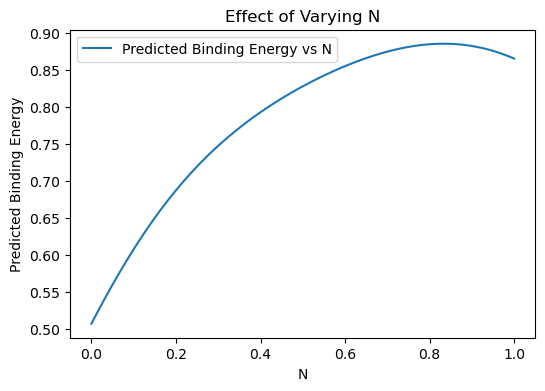

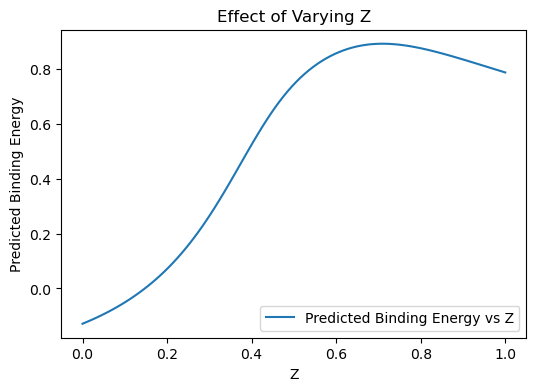

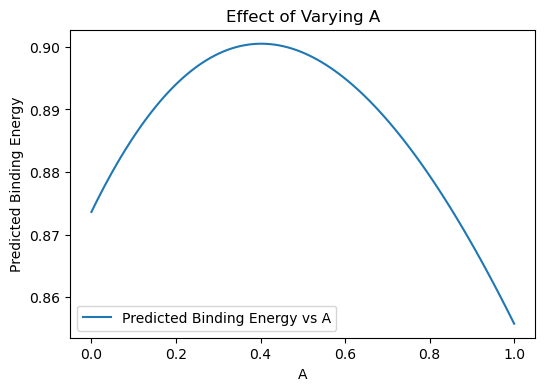

In [25]:
D = df[FEATURES]
features_to_vary = ['N', 'Z', 'A']

for varying_feature in features_to_vary:
    # Choose a feature to vary and fix others
    fixed_values = D.iloc[0].copy()  # Take a sample point as the baseline

    # Vary the selected feature
    varying_range = np.linspace(D[varying_feature].min(), D[varying_feature].max(), 100)

    # Create a DataFrame to hold varied data
    varied_data = pd.DataFrame([fixed_values] * len(varying_range))
    varied_data[varying_feature] = varying_range

    # Predict binding energy for the varied feature
    predicted_binding = model(torch.tensor(varied_data.values).float()).detach().numpy()

    # Plot predictions vs. the varied feature
    plt.figure(figsize=(6, 4))
    plt.plot(varying_range, predicted_binding, label=f"Predicted Binding Energy vs {varying_feature}")
    plt.xlabel(f"{varying_feature}")
    plt.ylabel("Predicted Binding Energy")
    plt.title(f"Effect of Varying {varying_feature}")
    plt.legend()
    filename = f"feature_importance_{varying_feature}.png"
    plt.savefig(filename)
    plt.show()
